# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake
## Data Validation and Cleaning
## The dataset
This data set has 947 rows, 8 columns. I have validated all variables and some changes I've made after validation :
- Impute `calories`, `carbohydrate`, `sugar`, `protein` columns by median.
- Cleaning both `category` and `servings`.
- Fill missing data of `high_traffic` with 'Not High'.
- Covert the data type of `category`, `servings`, and `high_traffic` columns to categorical type.

| Column | Description |
|--------|-------------|
| `recipe` | 947 unique values without missing values, same as description. No cleaning.|
| `calories` |  Numeric values as described, containing 52 missing values. Cleaned using imputation.|
| `carbohydrate` |Numeric values as described, containing 52 missing values. Cleaned using imputation.|
| `sugar` | Numeric values as described, containing 52 missing values. Cleaned using imputation.|
| `protein` | Numeric values as described, containing 52 missing values. Cleaned using imputation.|
| `category` | Character values as described, "Chicken Breast" category was in the dataset, not as description. Cleaned by replacing "Chicken Breast" by "Chicken" then converted to categorical type|
| `servings` | Character values not as described due to "4 as a snack" and "6 as a snack" values, replace "4 as a snack" with 2 and "6 as a snack" with 4, then converted to categorical type|
| `high_traffic` | Character values with missing data represent 'Not High', fill missing data with 'Not High', then convert the column to categorical type|

In [97]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score

In [98]:
# Import the dataset
recipes = pd.read_csv('recipe_site_traffic_2212.csv')

In [99]:
# Create a copy of the original DataFrame
recipes_cleaned = recipes.copy()

In [100]:
def validate_dtype(df, column, dtype):
    """
    Validate that the data type of the column in a DataFrame matches dtype.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the column to validate.
    column : str
        The name of the column whose data type is to be validated.
    dtype : type
        The expected data type to compare against.

    Returns
    -------
    None
        This function raises an AssertionError if the data type does not match.
    """
    
    # Check if the data type of the specified column matches the expected data type
    assert df[column].dtype == dtype, f"Data type mismatch: expected {dtype}, got {df[column].dtype}"

In [101]:
# Validate that the ``recipe`` has no duplicates
assert recipes_cleaned['recipe'].duplicated().sum() == 0

# Validate ``recipe`` column is of numerical type
validate_dtype(recipes_cleaned, 'recipe', 'int')

# Validate that the ``recipe`` column contains no missing values
assert recipes_cleaned['recipe'].isna().sum() == 0

# Set the ``recipe`` column as index
recipes_cleaned.set_index('recipe', inplace=True)

In [102]:
# Replace 'NAN' value with 'Not High'
recipes_cleaned['high_traffic'].fillna('Not High', inplace=True)

# Print the different values of ``high_traffic`` column
assert list(recipes_cleaned['high_traffic'].unique()) == ['High', 'Not High']

# Covert the variable high_traffic to categorical
recipes_cleaned['high_traffic'] = recipes_cleaned['high_traffic'].astype('category')

# Validate the changes
validate_dtype(recipes_cleaned, 'high_traffic', 'category')

### Cleaning & Validating `calories`, `carbohydrate`, `sugar` , and `protein` columns
- The `calories`, `carbohydrate`, `sugar`, and `protein` columns had 52 rows in common with missing data. After investigation, the missing values were imputed using the median due to high skewness (as discussed later in the Exploratory Analysis section) of their respective `category` type group.
- The columns contain outliers; however, due to their high percentage (above 5%), they do not indicate erroneous inputs, so I left them as they are.

In [103]:
# Validate ``calories``, ``carbohydrate``, ``sugar``, ``protein`` columns are of numerical type
cols = ['calories', 'carbohydrate', 'sugar', 'protein']

for col in cols:
    validate_dtype(recipes_cleaned, col, 'float')

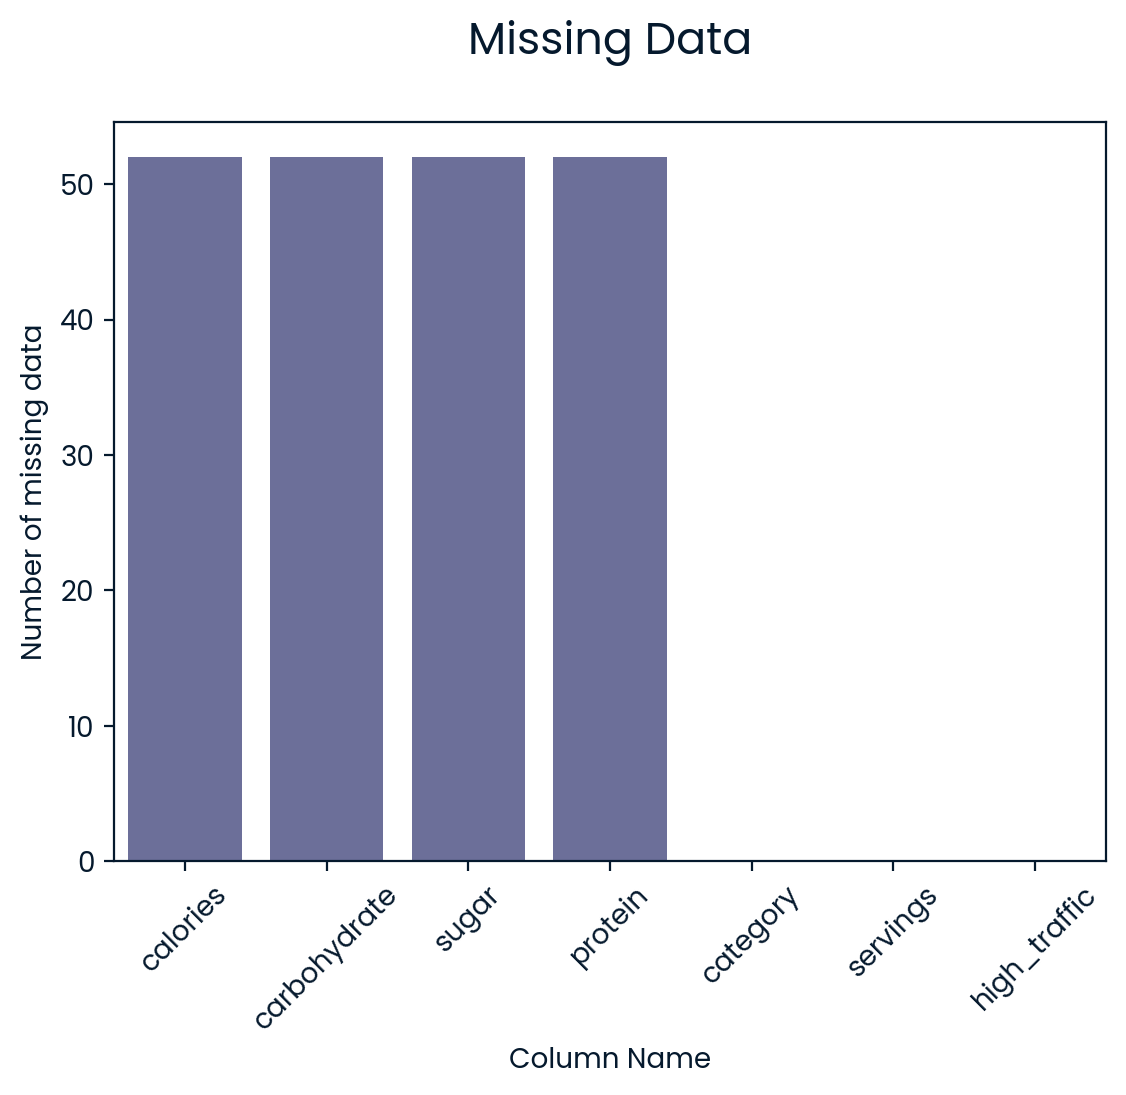

In [104]:
# Calculate the number of missing data in each column
missing_data = recipes_cleaned.isna().sum()

# Check the missing values in each column
sns.barplot(x=missing_data.index, y=missing_data.values)

# Rotate x-labels by 45 degrees
plt.xticks(rotation=45)

# Set labels for x and y axes
plt.xlabel("Column Name")
plt.ylabel("Number of missing data")

# Set a title
plt.title("Missing Data\n", fontsize=16)

# Show the plot
plt.show()

In [105]:
# Impute missing values by the median of each subgroup (category)
columns_to_impute = ['calories', 'carbohydrate', 'sugar', 'protein']

for col in columns_to_impute:
    # Calulate the median of the column of its ``category`` type
    col_dict = recipes_cleaned.groupby('category')[col].median().to_dict()
    
    # Impute
    recipes_cleaned[col] = recipes_cleaned[col].fillna(recipes_cleaned['category'].map(col_dict))

In [106]:
def get_outliers(df, column):
    
    """
    Subset the outliers of a given dataset column using the IQR method.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data from which to identify outliers.
    column : str
        The name of the column in which to detect outliers.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the outliers for the specified column.
    """
    
    # Find the 75th and 25th percentiles
    seventy_fifth = df[column].quantile(0.75)
    twenty_fifth = df[column].quantile(0.25)

    # Calculate iqr
    iqr = seventy_fifth - twenty_fifth

    # Calculate the thresholds
    upper = seventy_fifth + (1.5 * iqr)
    lower = twenty_fifth - (1.5 * iqr)

    # Calculate the number of outliers
    outliers = df[(df[column] <= lower) | (df[column] >= upper)]

    # Return the outliers
    return outliers

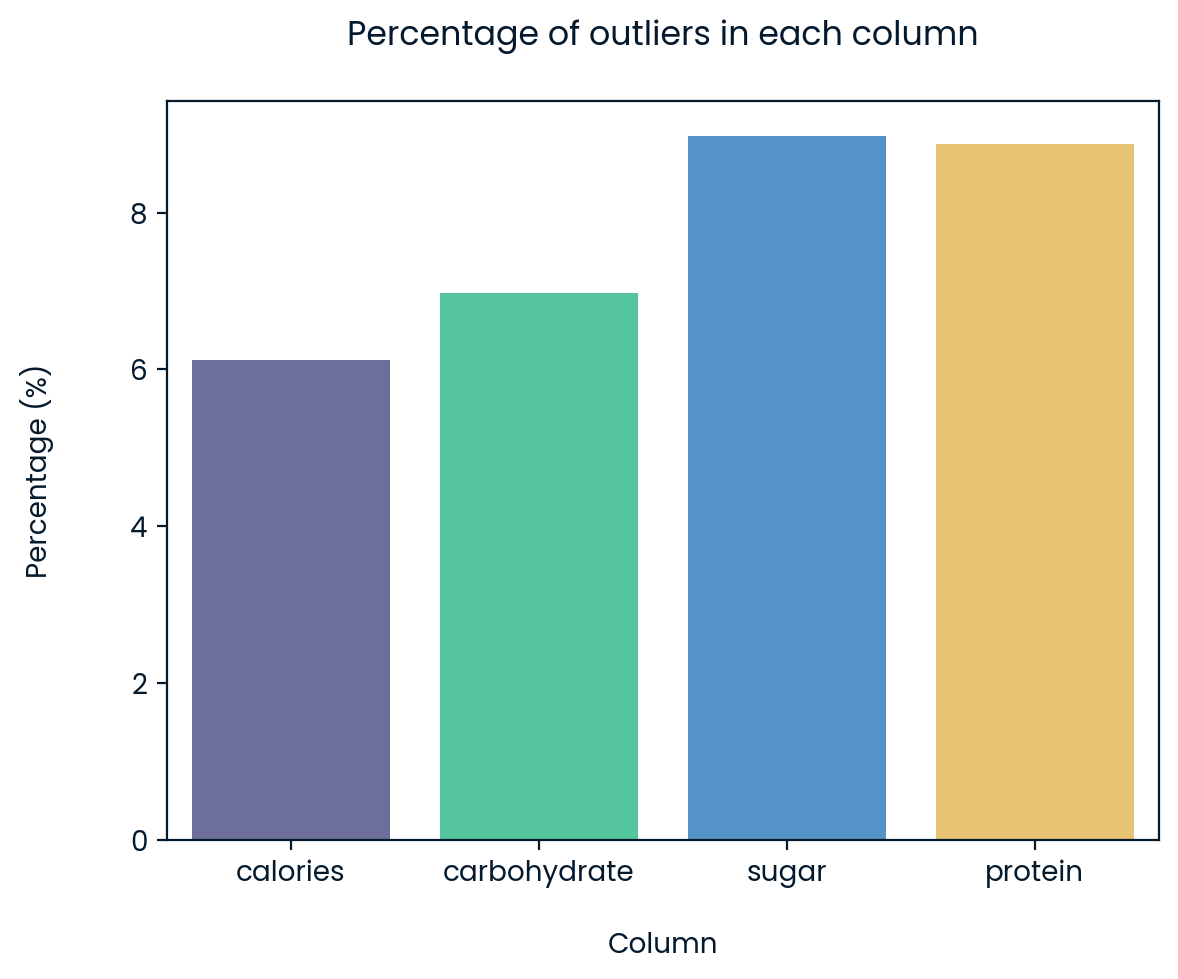

In [107]:
# Define the columns to analyze for outliers
cols = ['calories', 'carbohydrate', 'sugar', 'protein']

# Get the total number of observations in the recipe dataset
n_obs = len(recipes_cleaned)

# Initialize a list to store the percentage of outliers for each column
percentages = []

# Calculate the percentage of outliers for each specified column
for col in cols:
    # Get the number of outliers in the current column
    n_outliers = len(get_outliers(recipes_cleaned, col))
    
    # Calculate the percentage of outliers and append to the list
    percentages.append(round((n_outliers / n_obs) * 100, 2))

# Create a bar plot for the percentage of outliers for each column
sns.barplot(x=cols, y=percentages, hue=cols)

# Set the x-axis label
plt.xlabel('\nColumn')

# Set the y-axis label
plt.ylabel('Percentage (%)\n\n')

# Set the plot title
plt.title('Percentage of outliers in each column\n')

# Display the plot
plt.show()

### Cleaning & Validating `category` and `servings` colunms
- The `category` column does not match the information provided by the Head of Data Science, as it includes an additional category: 'Chicken Breast'. Therefore, I replaced it with just 'Chicken'.
- The `savings` column wasn't numerical as it contains ambiguous values: '4 as a snack' and '6 as a snack'. After investigation, I decided to replace the value '4 as a snack' with 2, meaning the recipe serves 2 for lunch, and '6 as a snack' was replaced with 4.
- The columns then converted to categorical type

In [108]:
# Exlore the `category` different values
list(recipes_cleaned['category'].unique())

['Pork',
 'Potato',
 'Breakfast',
 'Beverages',
 'One Dish Meal',
 'Chicken Breast',
 'Lunch/Snacks',
 'Chicken',
 'Vegetable',
 'Meat',
 'Dessert']

In [109]:
# Replace 'Chicken Breast' with 'Chicken' in the 'category' column
recipes_cleaned['category'] = recipes_cleaned['category'].str.replace('Chicken Breast', 'Chicken')

In [110]:
# Check the ``category`` contains one of the ten different values
list(recipes_cleaned['category'].unique())

['Pork',
 'Potato',
 'Breakfast',
 'Beverages',
 'One Dish Meal',
 'Chicken',
 'Lunch/Snacks',
 'Vegetable',
 'Meat',
 'Dessert']

In [111]:
# Explore the ``servings`` column
print(list(recipes_cleaned['servings'].unique()))

['6', '4', '1', '2', '4 as a snack', '6 as a snack']


In [112]:
# Replace '4 as a snack' with 2 and '6 as a snack' with 4
to_replace = {
    '4 as a snack' : '2',
    '6 as a snack' : '4',
}
recipes_cleaned['servings'] = recipes_cleaned['servings'].replace(to_replace)

# Convert the ``servings`` column to categorical data type
recipes_cleaned['servings'] = recipes_cleaned['servings'].astype('category')

# Check ``servings`` of categorical data type
validate_dtype(recipes_cleaned, 'servings', 'category')

## Exploratory Analysis
I investigated the target variable and the features of the recipes, as well as the relationships between the target variable and these features. After the analysis, I decided to apply the following changes to enable modeling:

- Remove the `servings` feature.

### Target variable - `high_traffic`
The goal is to predict whether the recipe will bring high traffic to the site; thus, our target variable is `high_traffic`. As shown in the pie chart below, the dataset contains more recipes likely to bring high traffic, with 61% classified as high traffic and 39% as not high traffic.

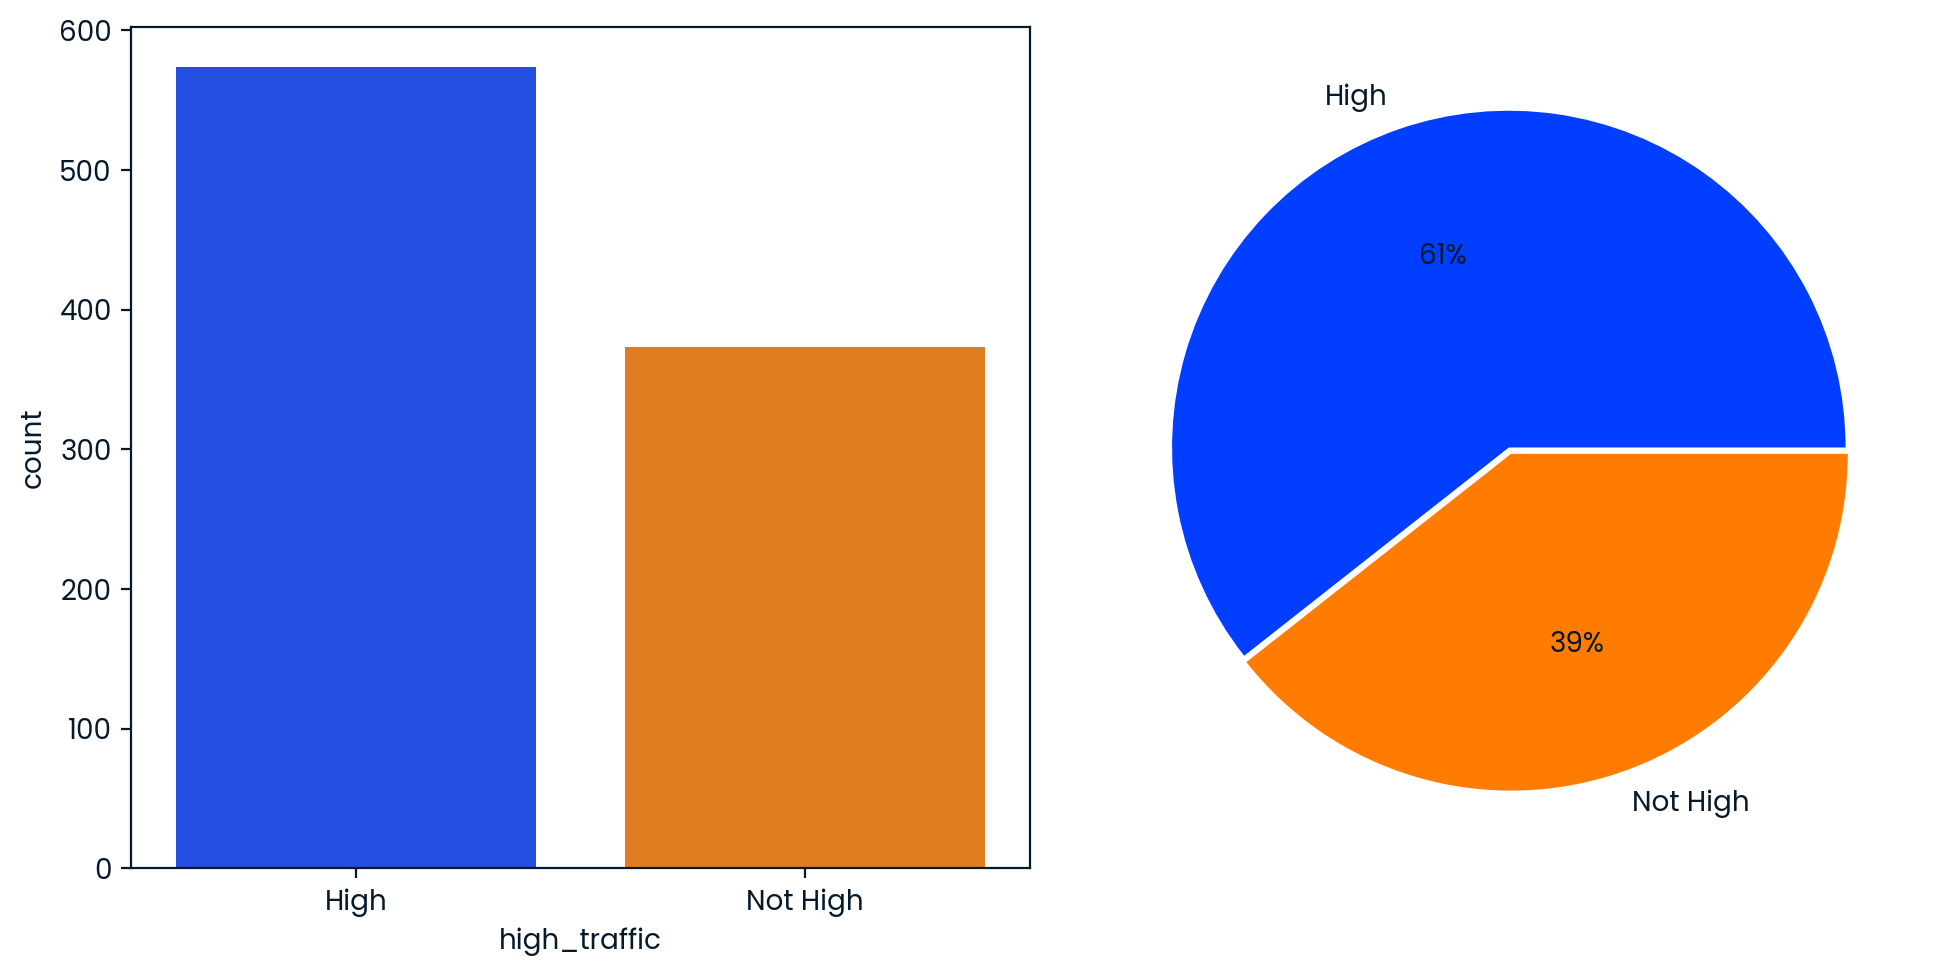

In [113]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# declaring exploding pie 
explode = [0, 0.020]

# define Seaborn color palette to use 
palette_color = sns.color_palette('bright') 

# Plot count ``high_traffic`` variable with a good color
sns.countplot(x='high_traffic', data=recipes_cleaned, ax=ax[0], palette=palette_color)

# Plot the ``high_traffic`` variable as a pie chart
ax[1].pie(recipes_cleaned['high_traffic'].value_counts(), labels=['High', 'Not High'], colors=palette_color, 
        explode=explode, autopct='%.0f%%')

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

# Display the plot
plt.show()

### Numeric Variables - `calories`, `carbohydrate`, `sugar`, and `protein`
The histograms and box plots of the numeric variables are shown below. As we can see from the histograms, all the variables are highly skewed to the right. Additionally, the box plots indicate that the variables contain values outside the IQR range. No action is needed.

In [114]:
def plot_distributions(df, column) :
    """
    Plot the distributions of a specified column in a DataFrame using a histogram and a box plot.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data to be plotted.
    column : str
        The name of the column for which the distributions will be plotted.

    Returns
    -------
    None
        This function displays the plots but does not return any values.
    """
    
    # Create a figure and a set of subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot histogram with kernel density estimate (KDE)
    sns.histplot(x=column, data=df, color='tomato', kde=True, ax=ax[0])
    ax[0].set_ylabel('Count')
    
    # Calculate the median
    median = df[column].median()
    
    # Calculate the mean
    mean = df[column].mean()
    
    # Plot the verticale lines
    ax[0].axvline(median, color='blue', linestyle='--', label=f'Median: {median:.2f}')
    ax[0].axvline(mean, color='green', linestyle='--', label=f'Mean: {mean:.2f}')
    ax[0].legend()
    
    # Plot box plot for the specified column
    sns.boxplot(y=column, data=df,  width=0.4, ax=ax[1])
    ax[1].set_ylabel(f'\n\n{column}')
    
    # Adjust space between subplots
    plt.subplots_adjust(wspace=0.3)
    
    # Set the overall title for the figure
    fig.suptitle(f'{column.title()} Distributions\n', fontsize=16)
    
    # Automatically adjust subplot parameters to give specified padding
    plt.tight_layout()
    
    # Display the plots
    plt.show()

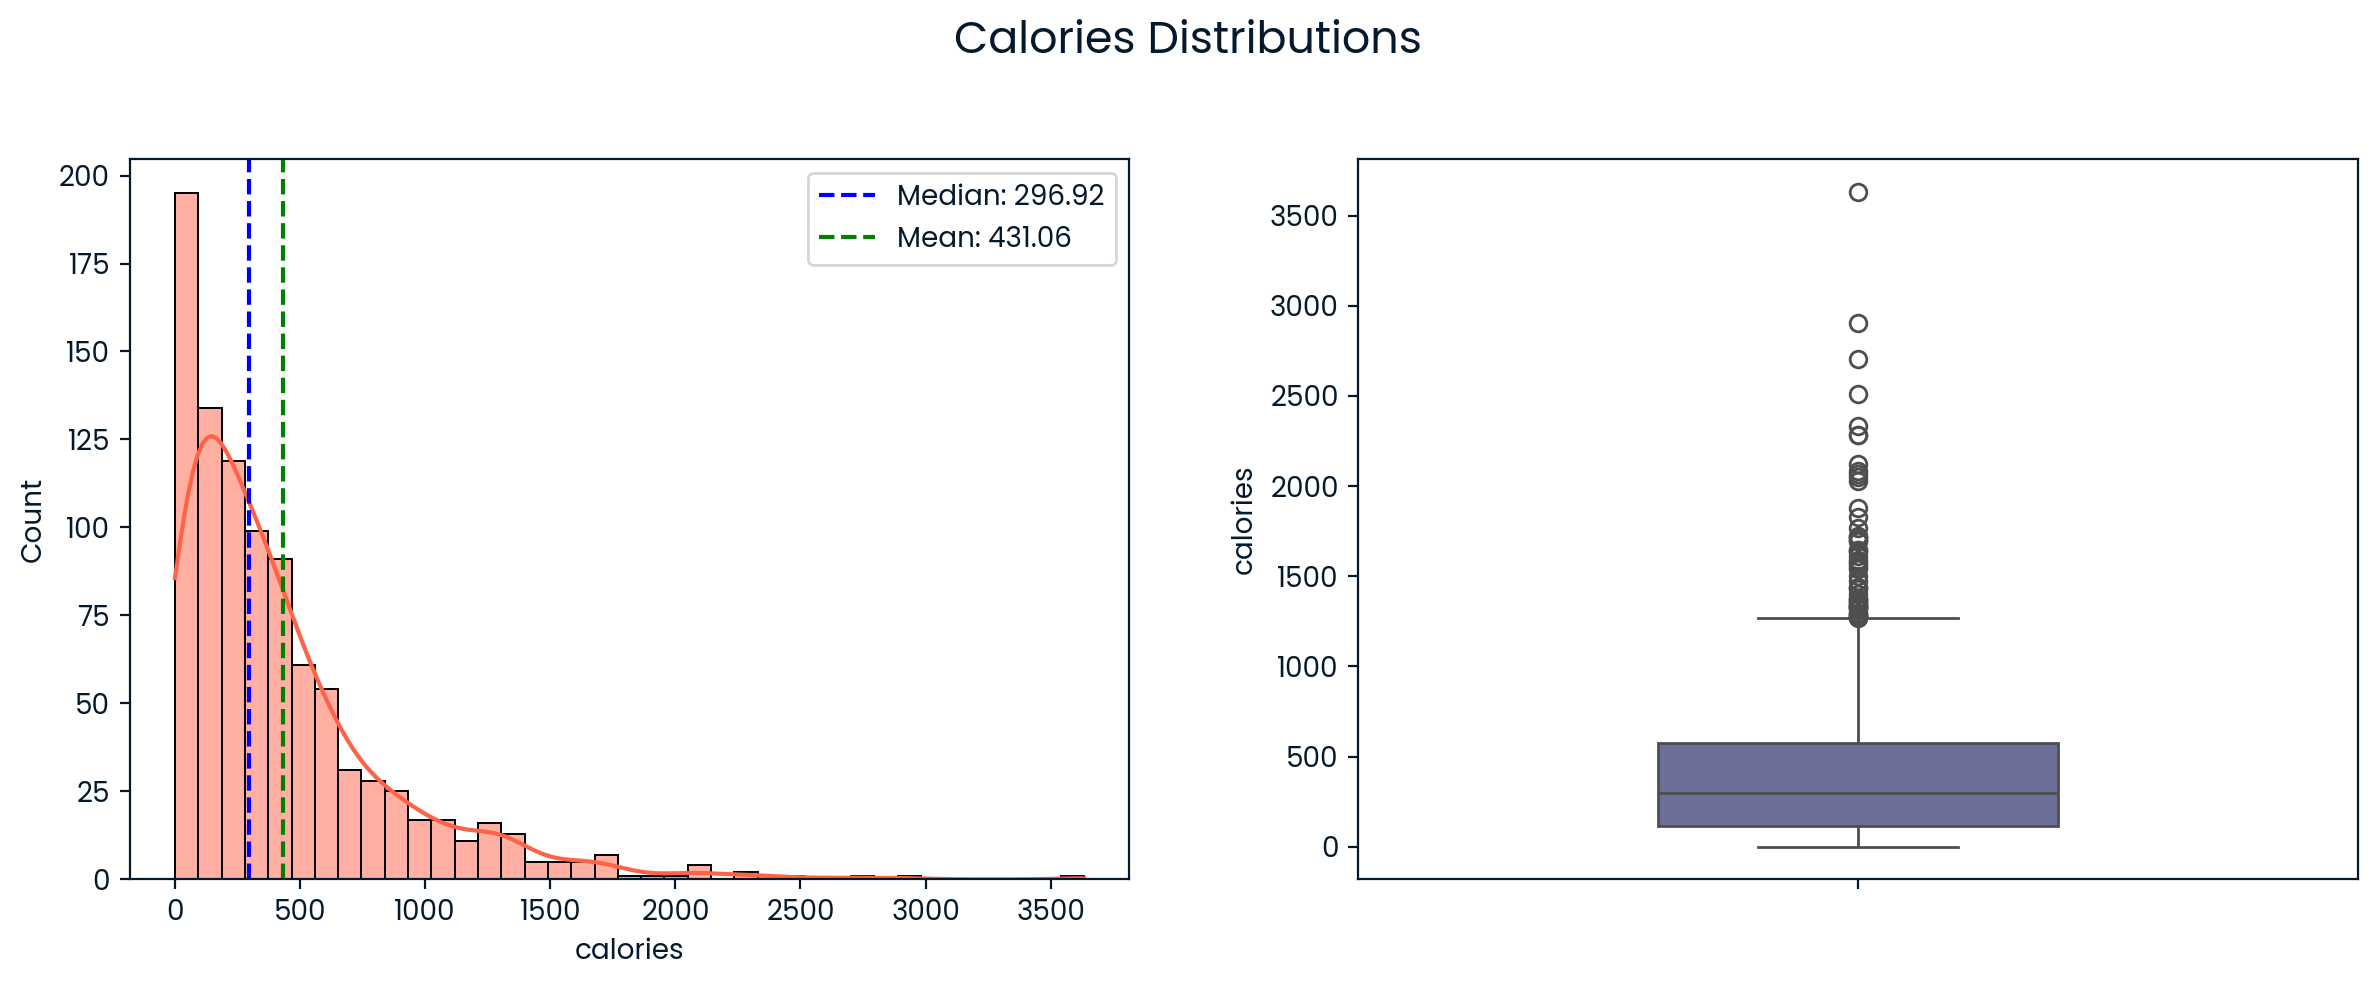

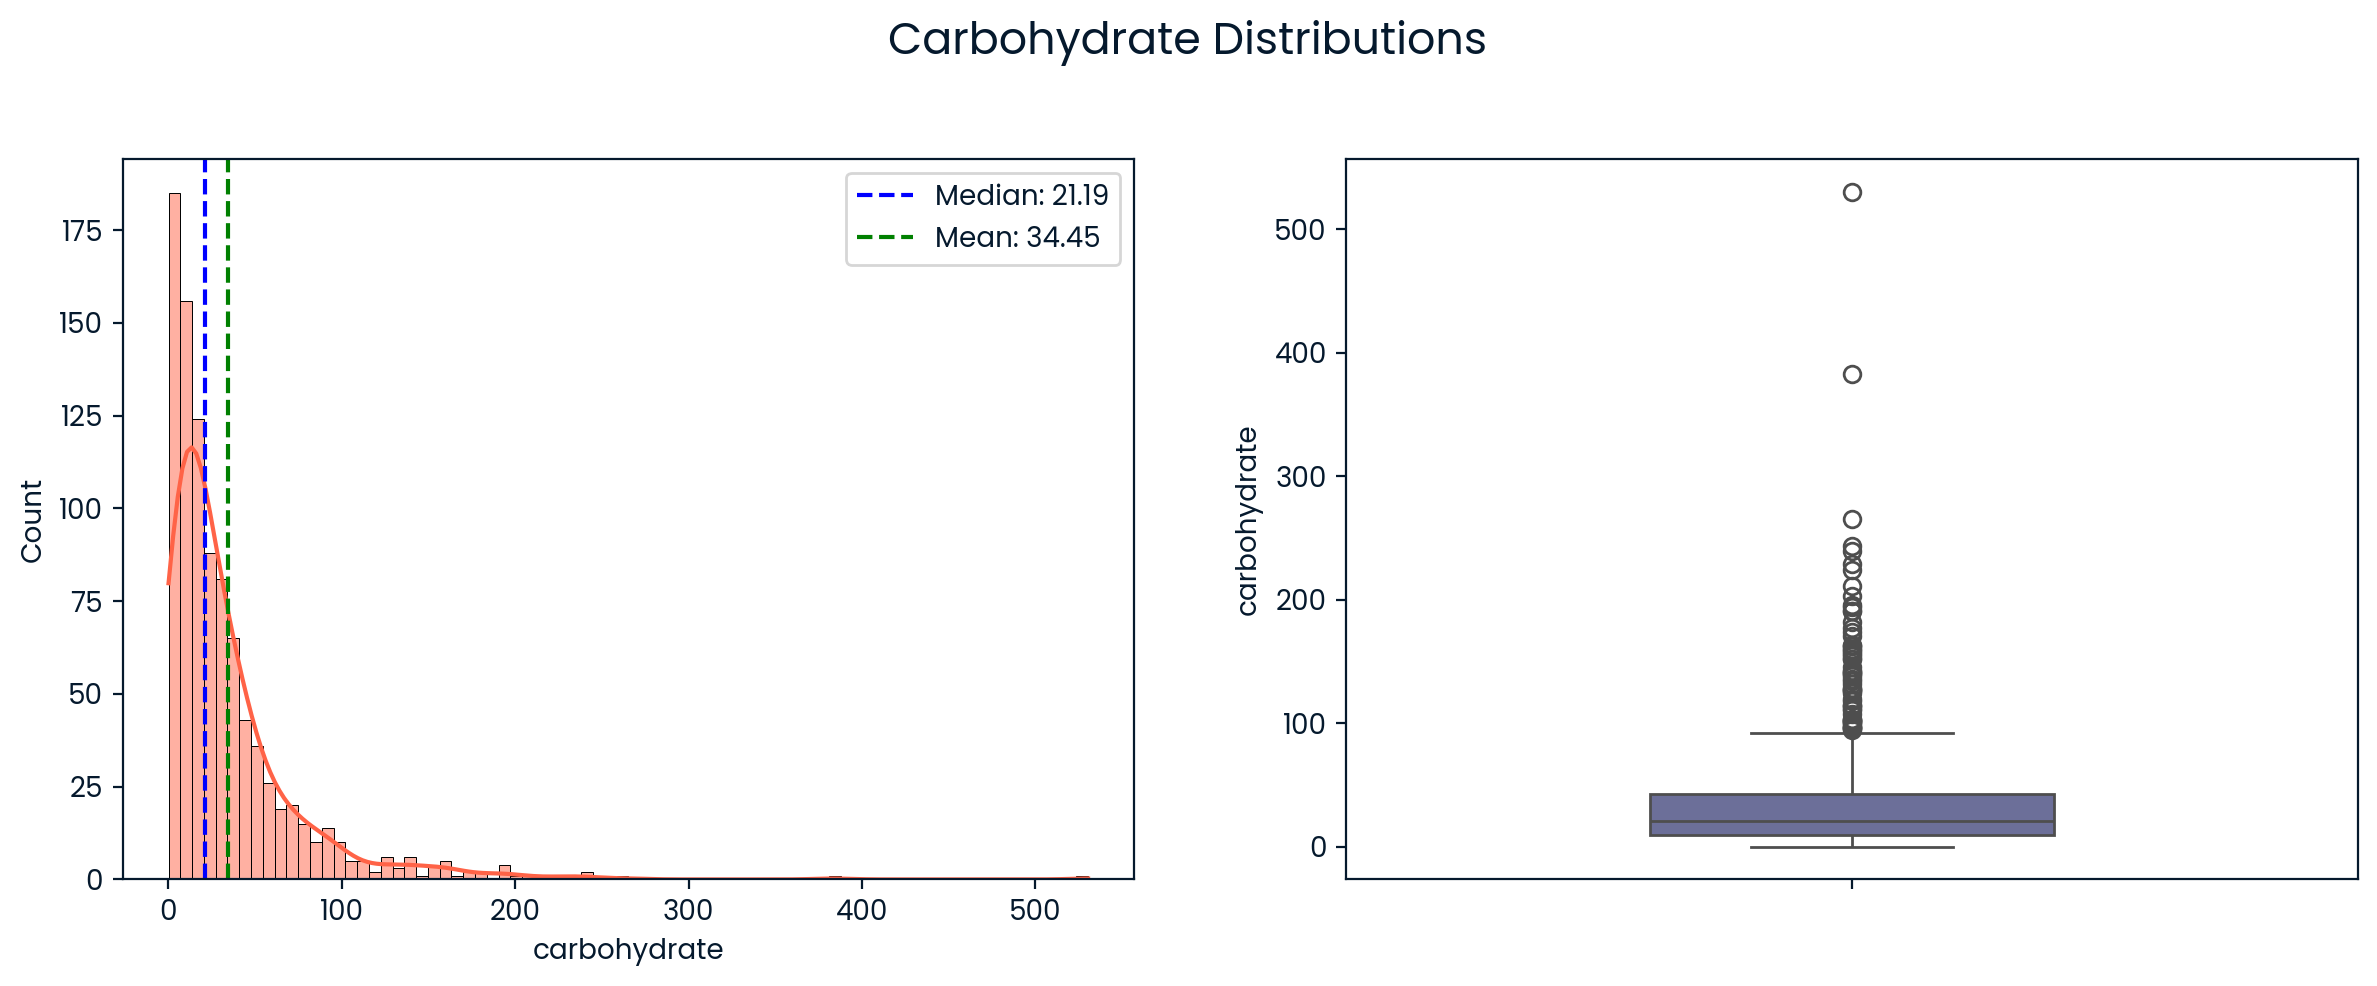

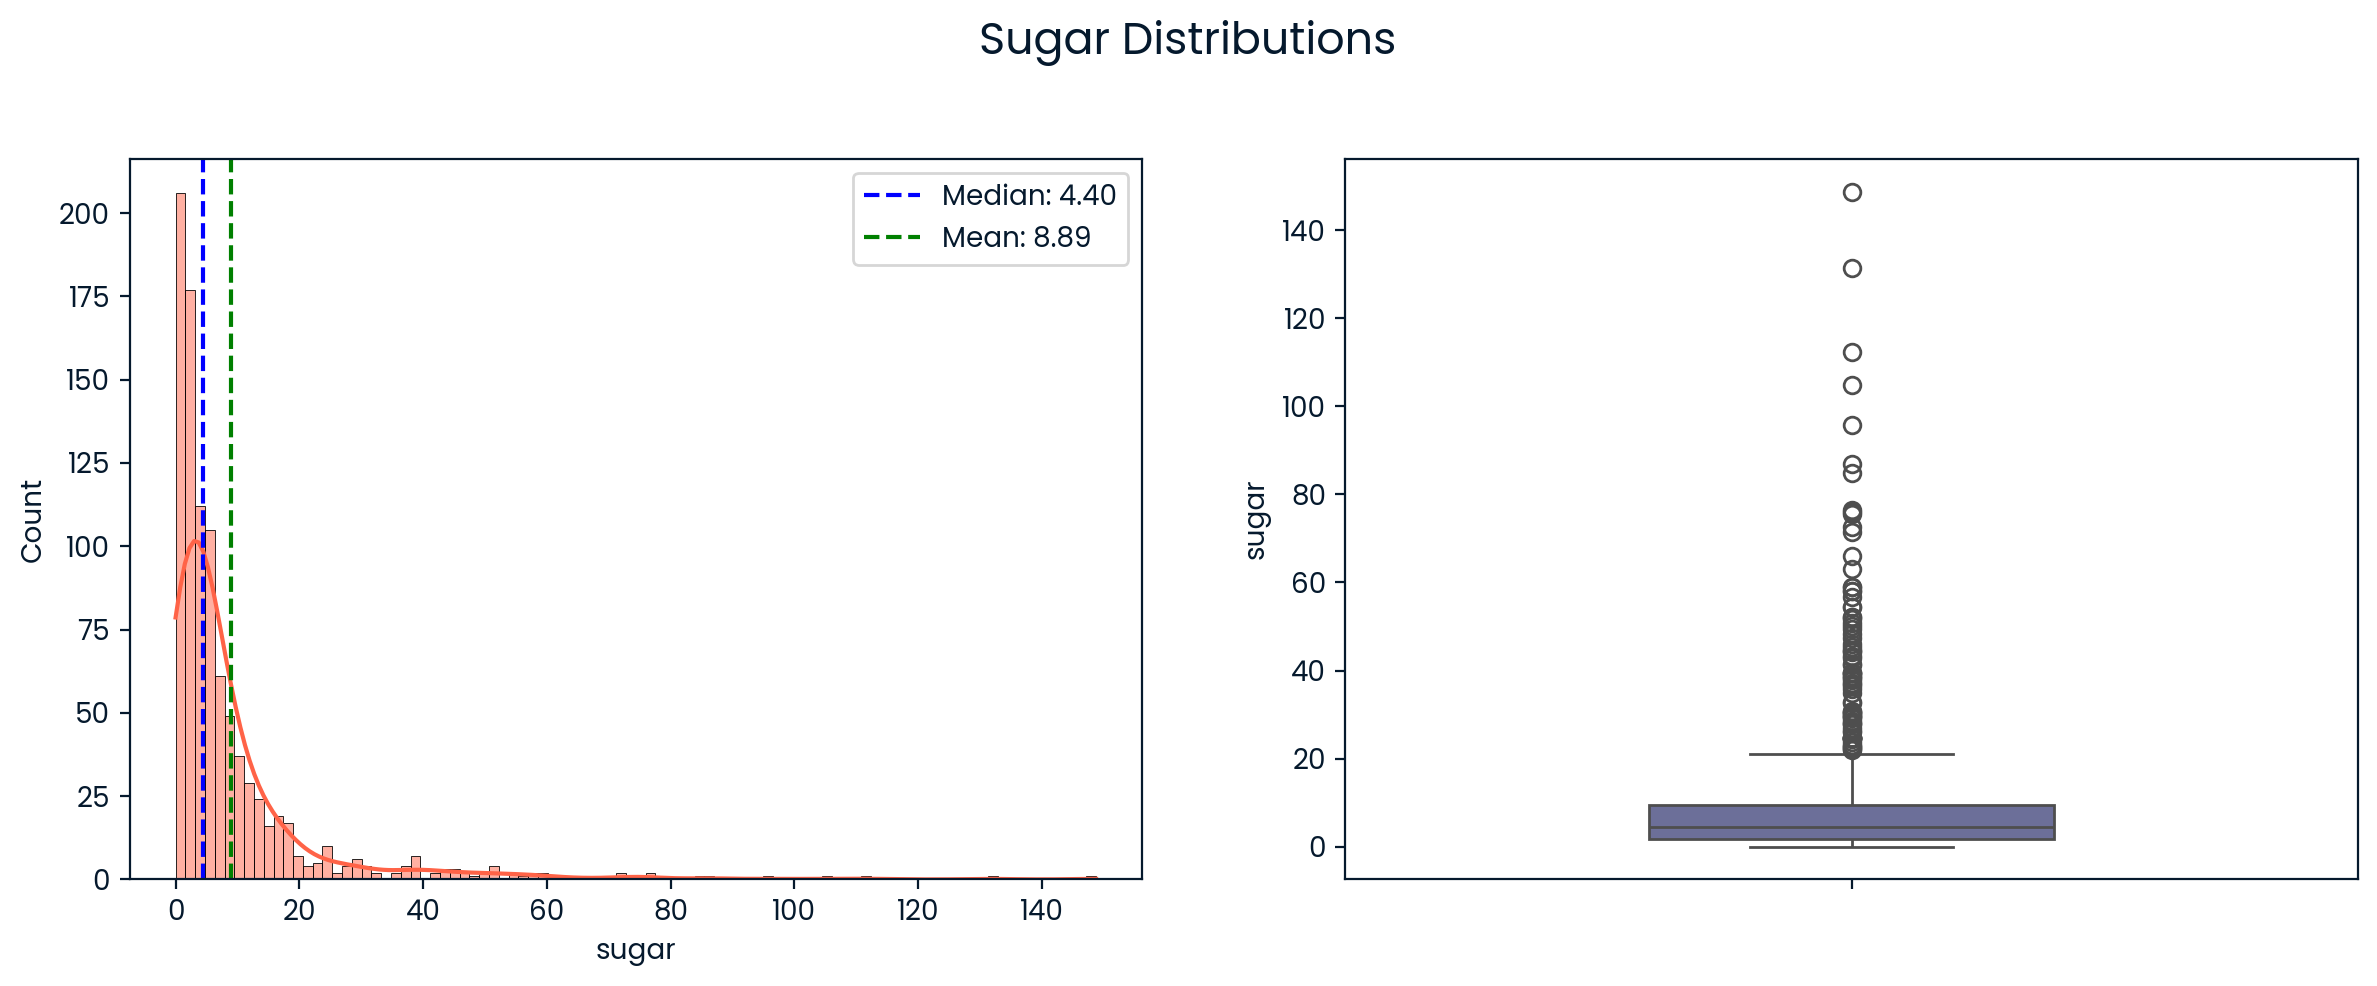

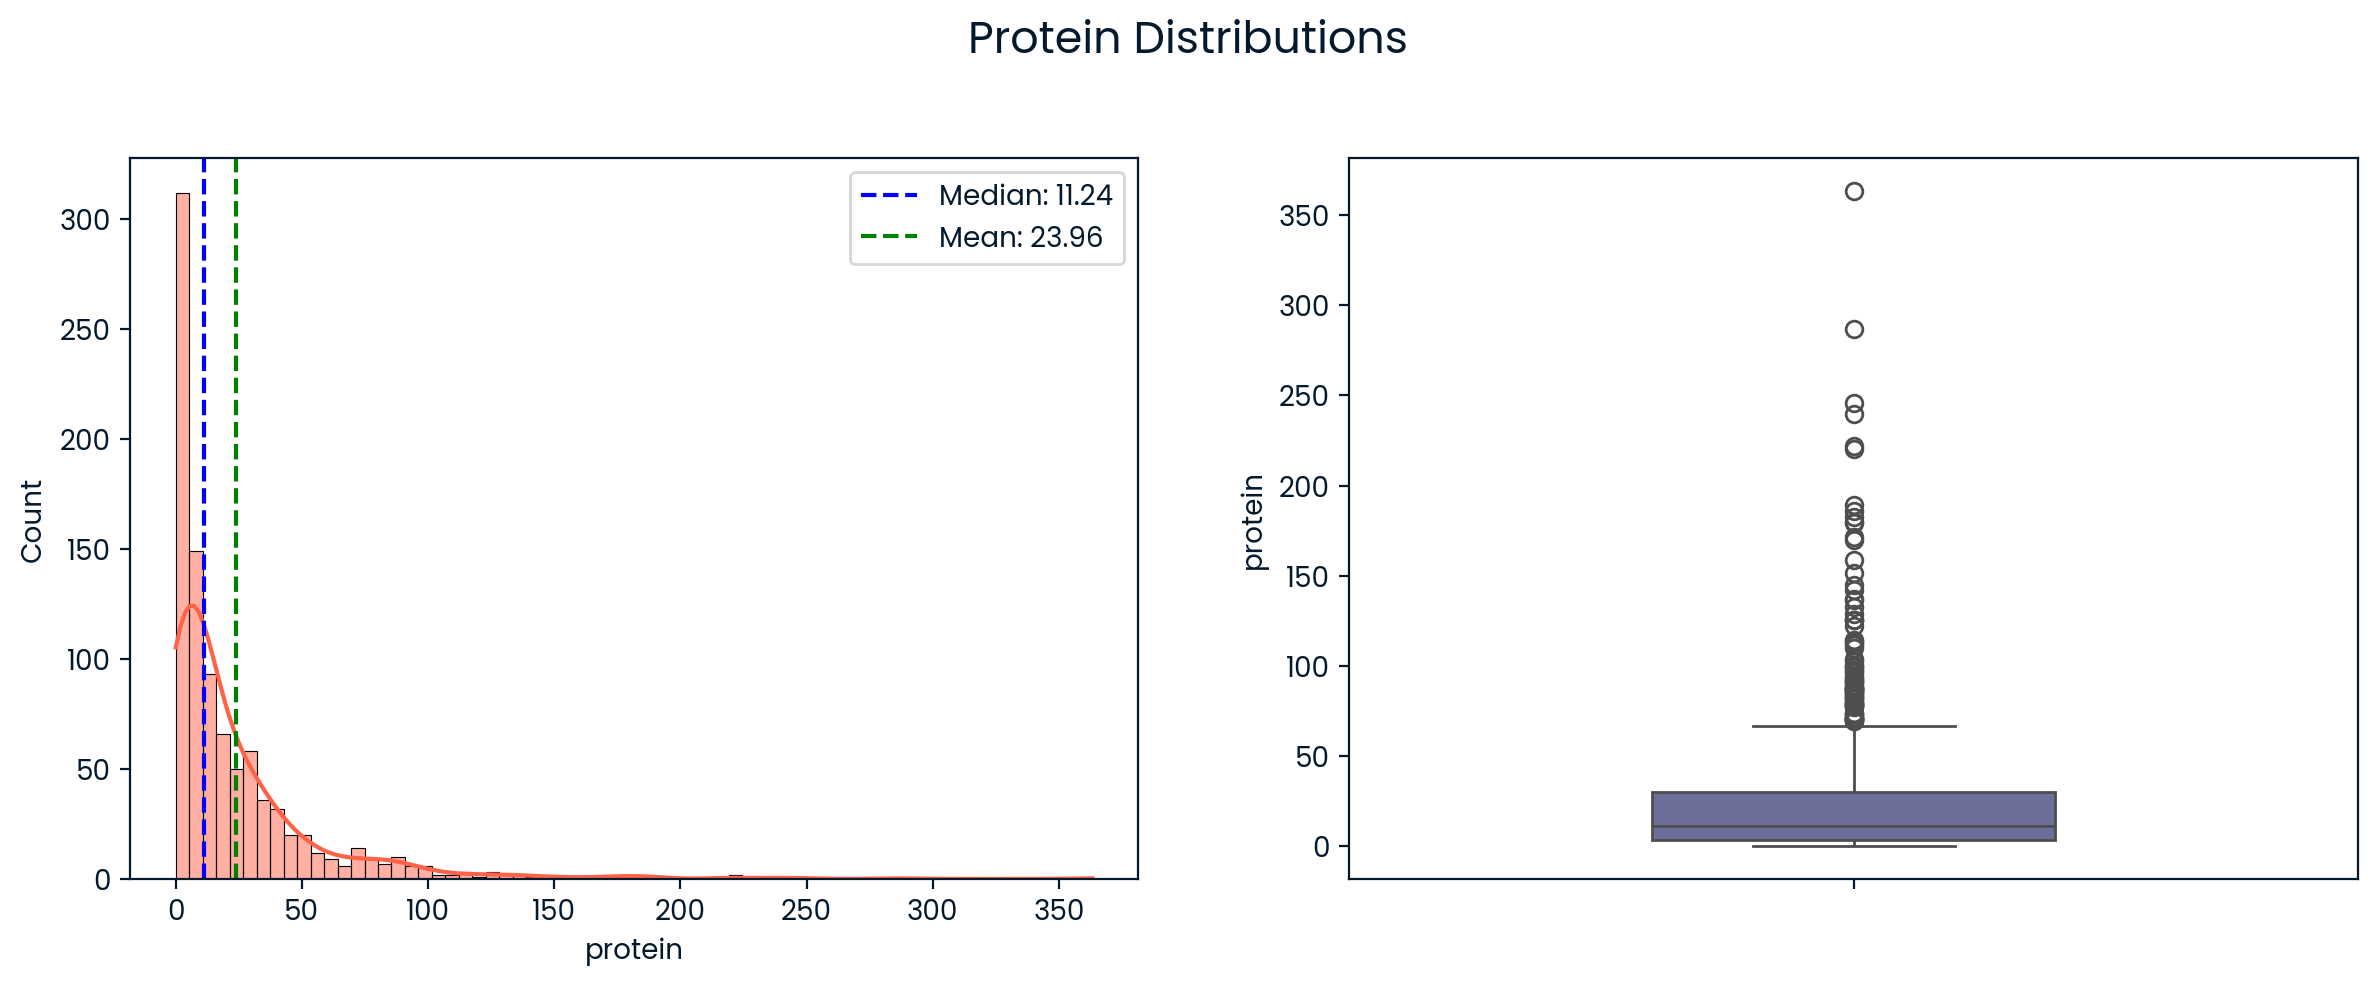

In [115]:
# Plot the distributions of the numerical columms
num_cols = ['calories', 'carbohydrate', 'sugar','protein']

for col in num_cols:
    # Plot
    plot_distributions(recipes_cleaned, col)

#### Relationship between `calories`, `carbohydrate`, `sugar`, `protein` and `high_traffic`
Below is a heatmap of the relationships between the numerical features and `high_traffic`. The strongest relationship displayed is between `calories` and `protein` showing a positive low correlation.

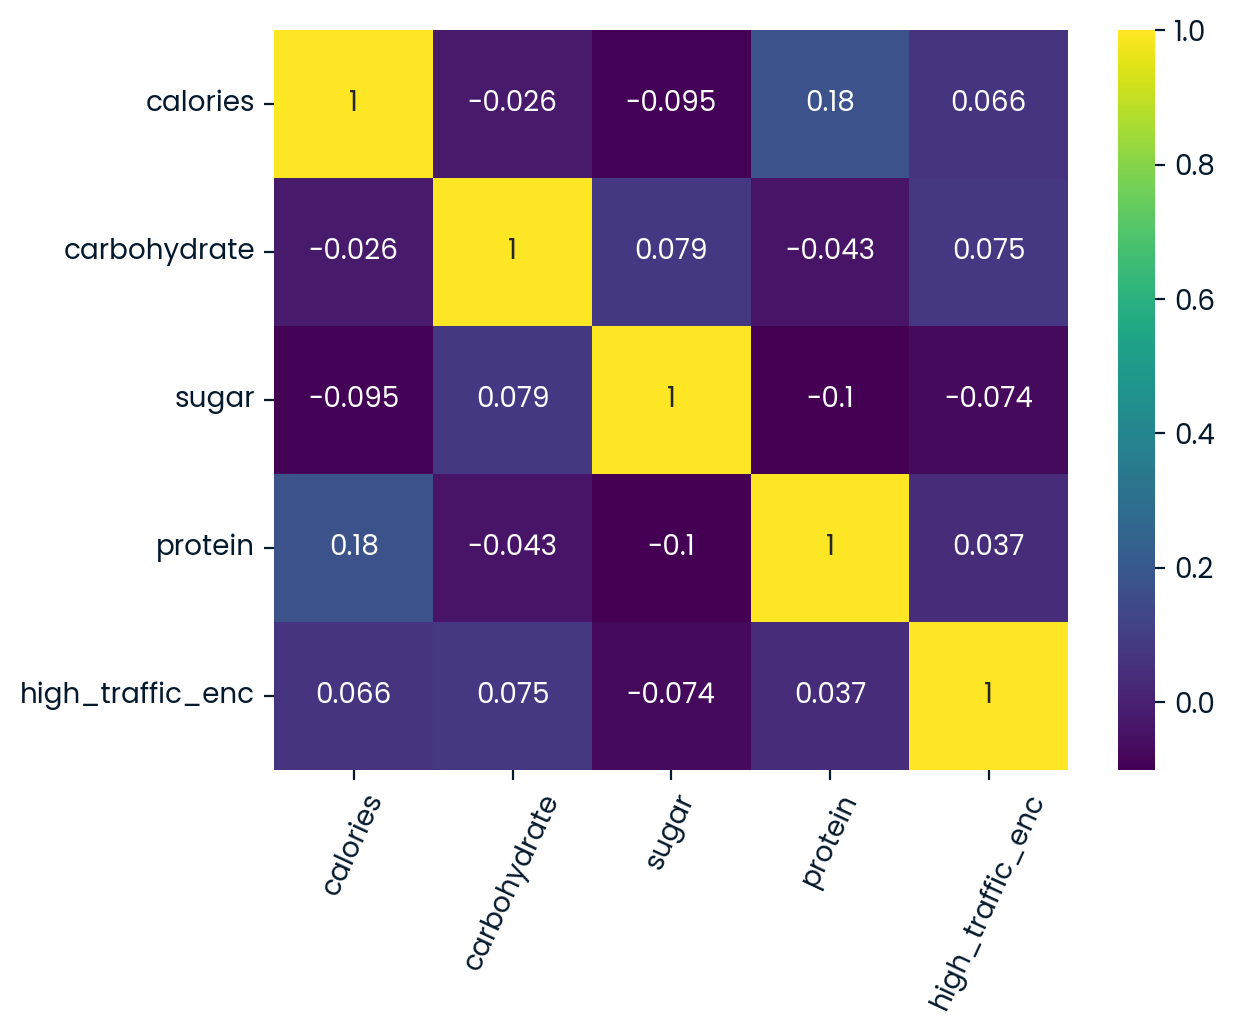

In [116]:
# Label encoding the target variable for the heatmap (i.e, high_traffic)
recipes_cleaned['high_traffic_enc'] = recipes_cleaned['high_traffic'].replace({'High':1, 'Not High':0}).astype('int8')

# Select columns for the correlation heatmap
cols = ['calories', 'carbohydrate', 'sugar' ,'protein', 'high_traffic_enc']

# Create heatmap of correlations
sns.heatmap(recipes_cleaned[cols].corr(), cmap='viridis', annot=True)

# Rotate x-labels by 65 degrees
plt.xticks(rotation=65)

# Rotate x-labels by 0 degrees
plt.yticks(rotation=0)

# Display the plot
plt.show()

### Categorical Variables - `category`, `servings`
- The recipe `category` types are slightly evenly distributed, with 'Chicken' having the largest proportion. Similarly, the `servings` feature shows that 4 servings represent 40%, a higher proportion compared to the others.

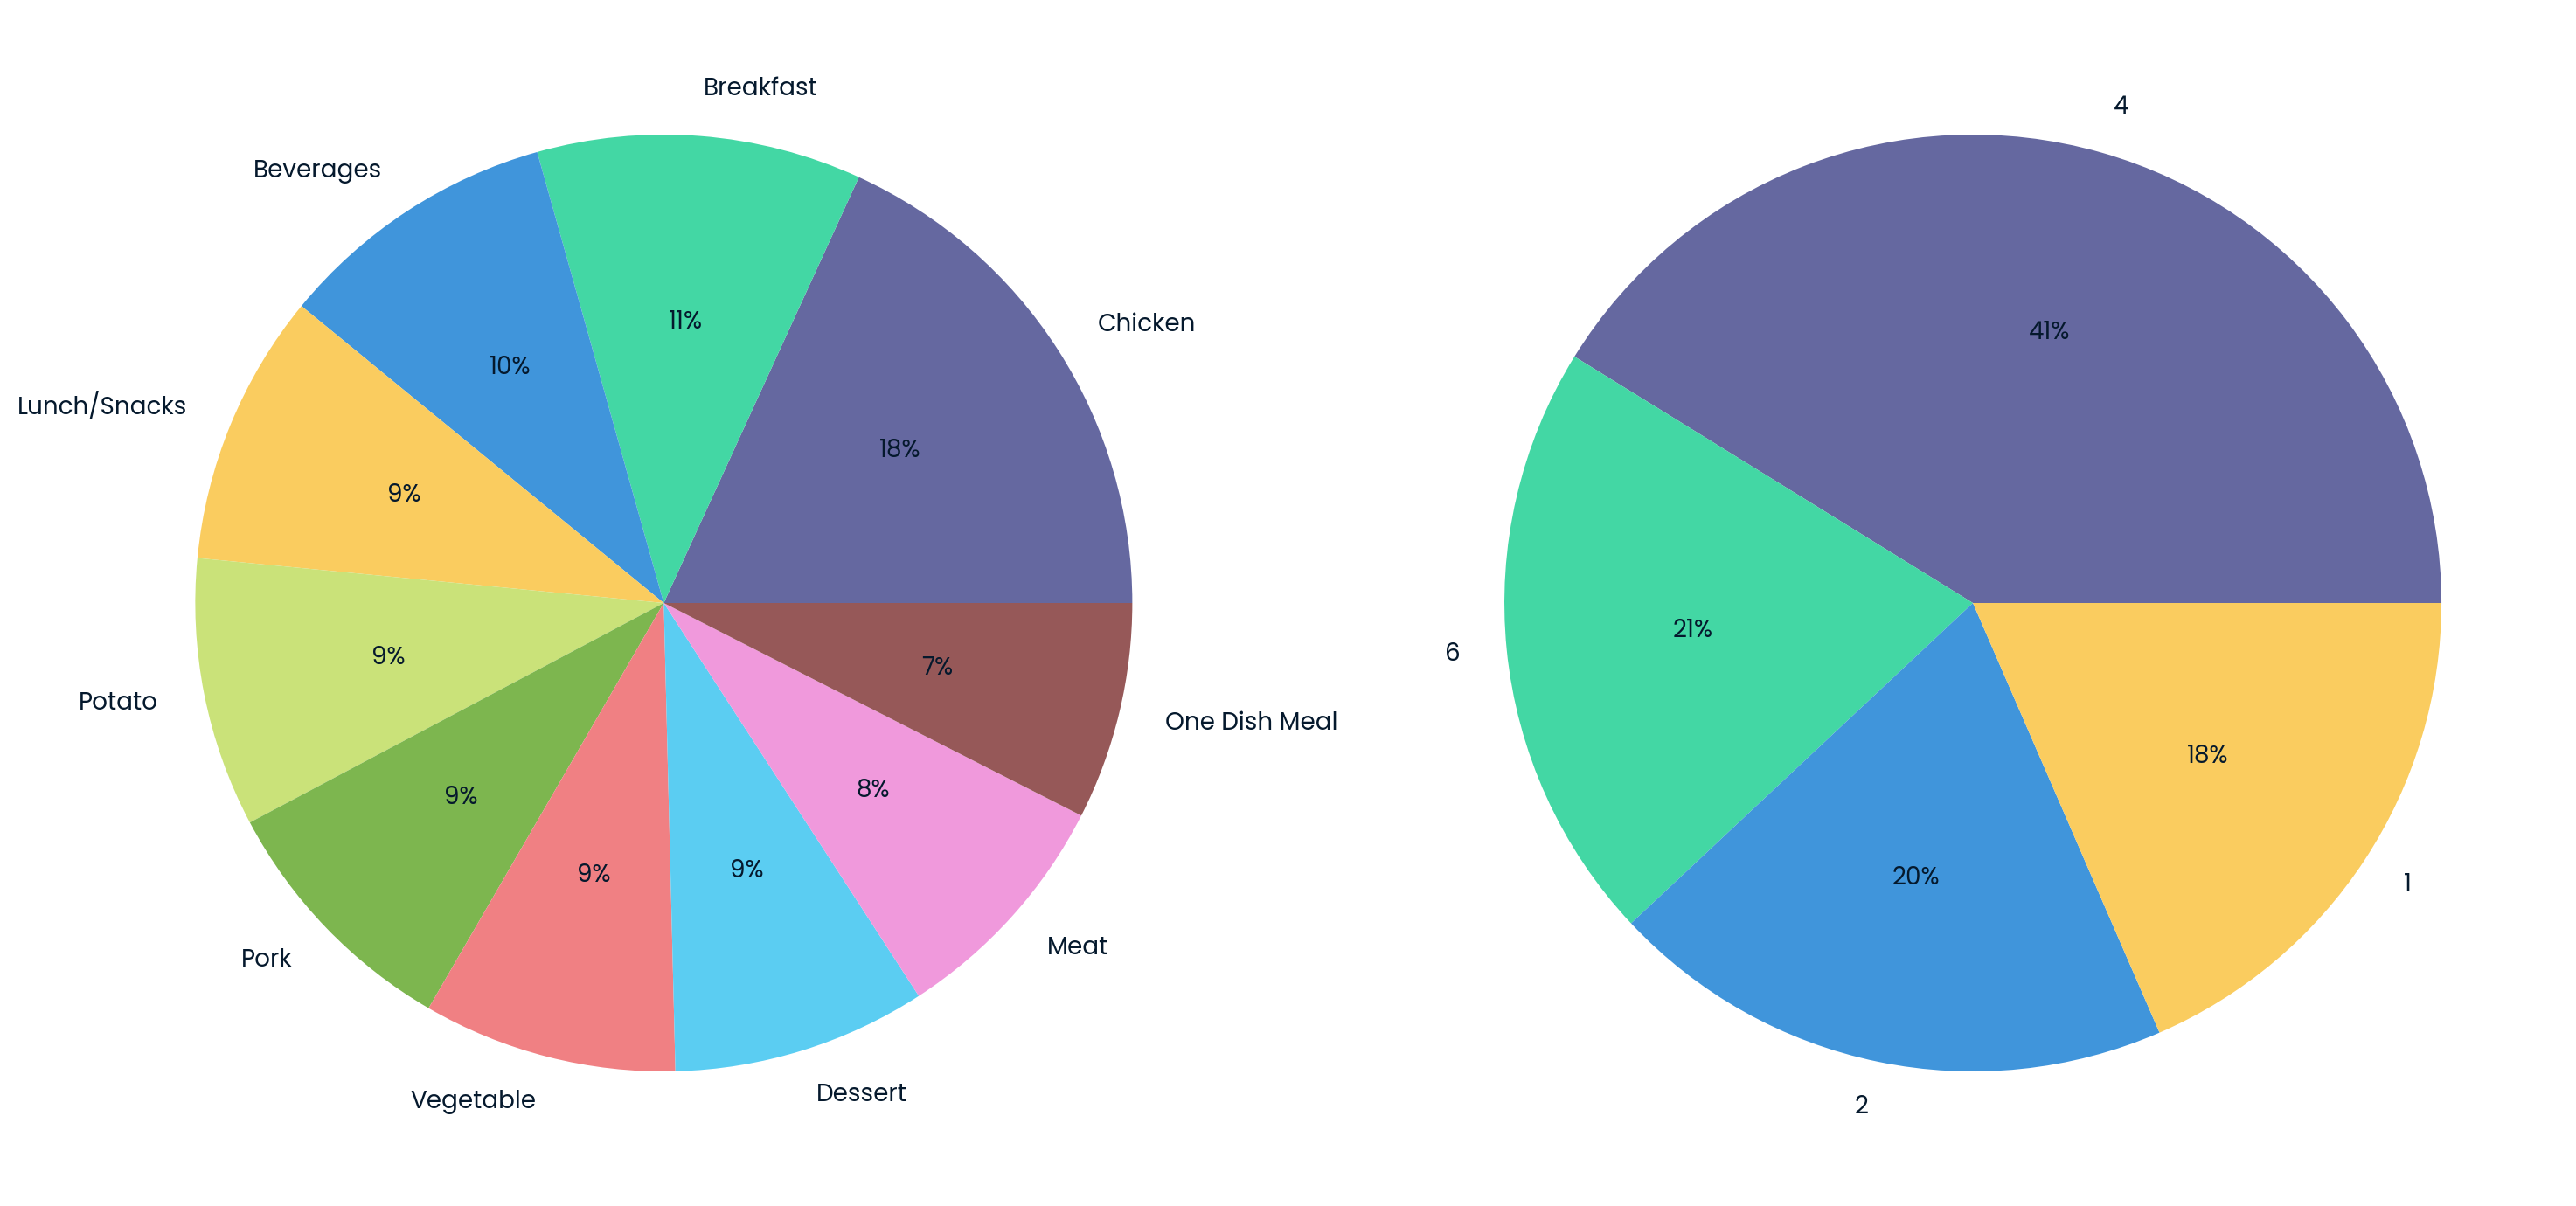

In [117]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

categories = recipes_cleaned['category'].value_counts()

# Plot the ``category`` variable as a pie chart
ax[0].pie(categories, labels=categories.index, autopct='%.0f%%')

servings = recipes_cleaned['servings'].value_counts()
# Plot the ``servings`` variable as a pie chart
ax[1].pie(servings, labels=servings.index, autopct='%.0f%%')

plt.tight_layout()

# Display the plot
plt.show()

#### Relationship between `category`, `servings`, and `high_traffic`
Below is the relationship between the categorical variables and the target using a count plot. We can see that the `category` variable appears to have a relationship with `high_traffic`. On the other hand, the `servings` variable does not seem to show a relationship with the `high_traffic` variable. Therefore, a chi-square test for proportions was conducted between the `category` variable and `high_traffic`, as well as between `servings` and `high_traffic`. Based on the results, I decided to:
- Remove the `servings` feature during modeling, as the p-value was much greater than alpha.
- Retain the `category` feature, as it showed a significant relationship.

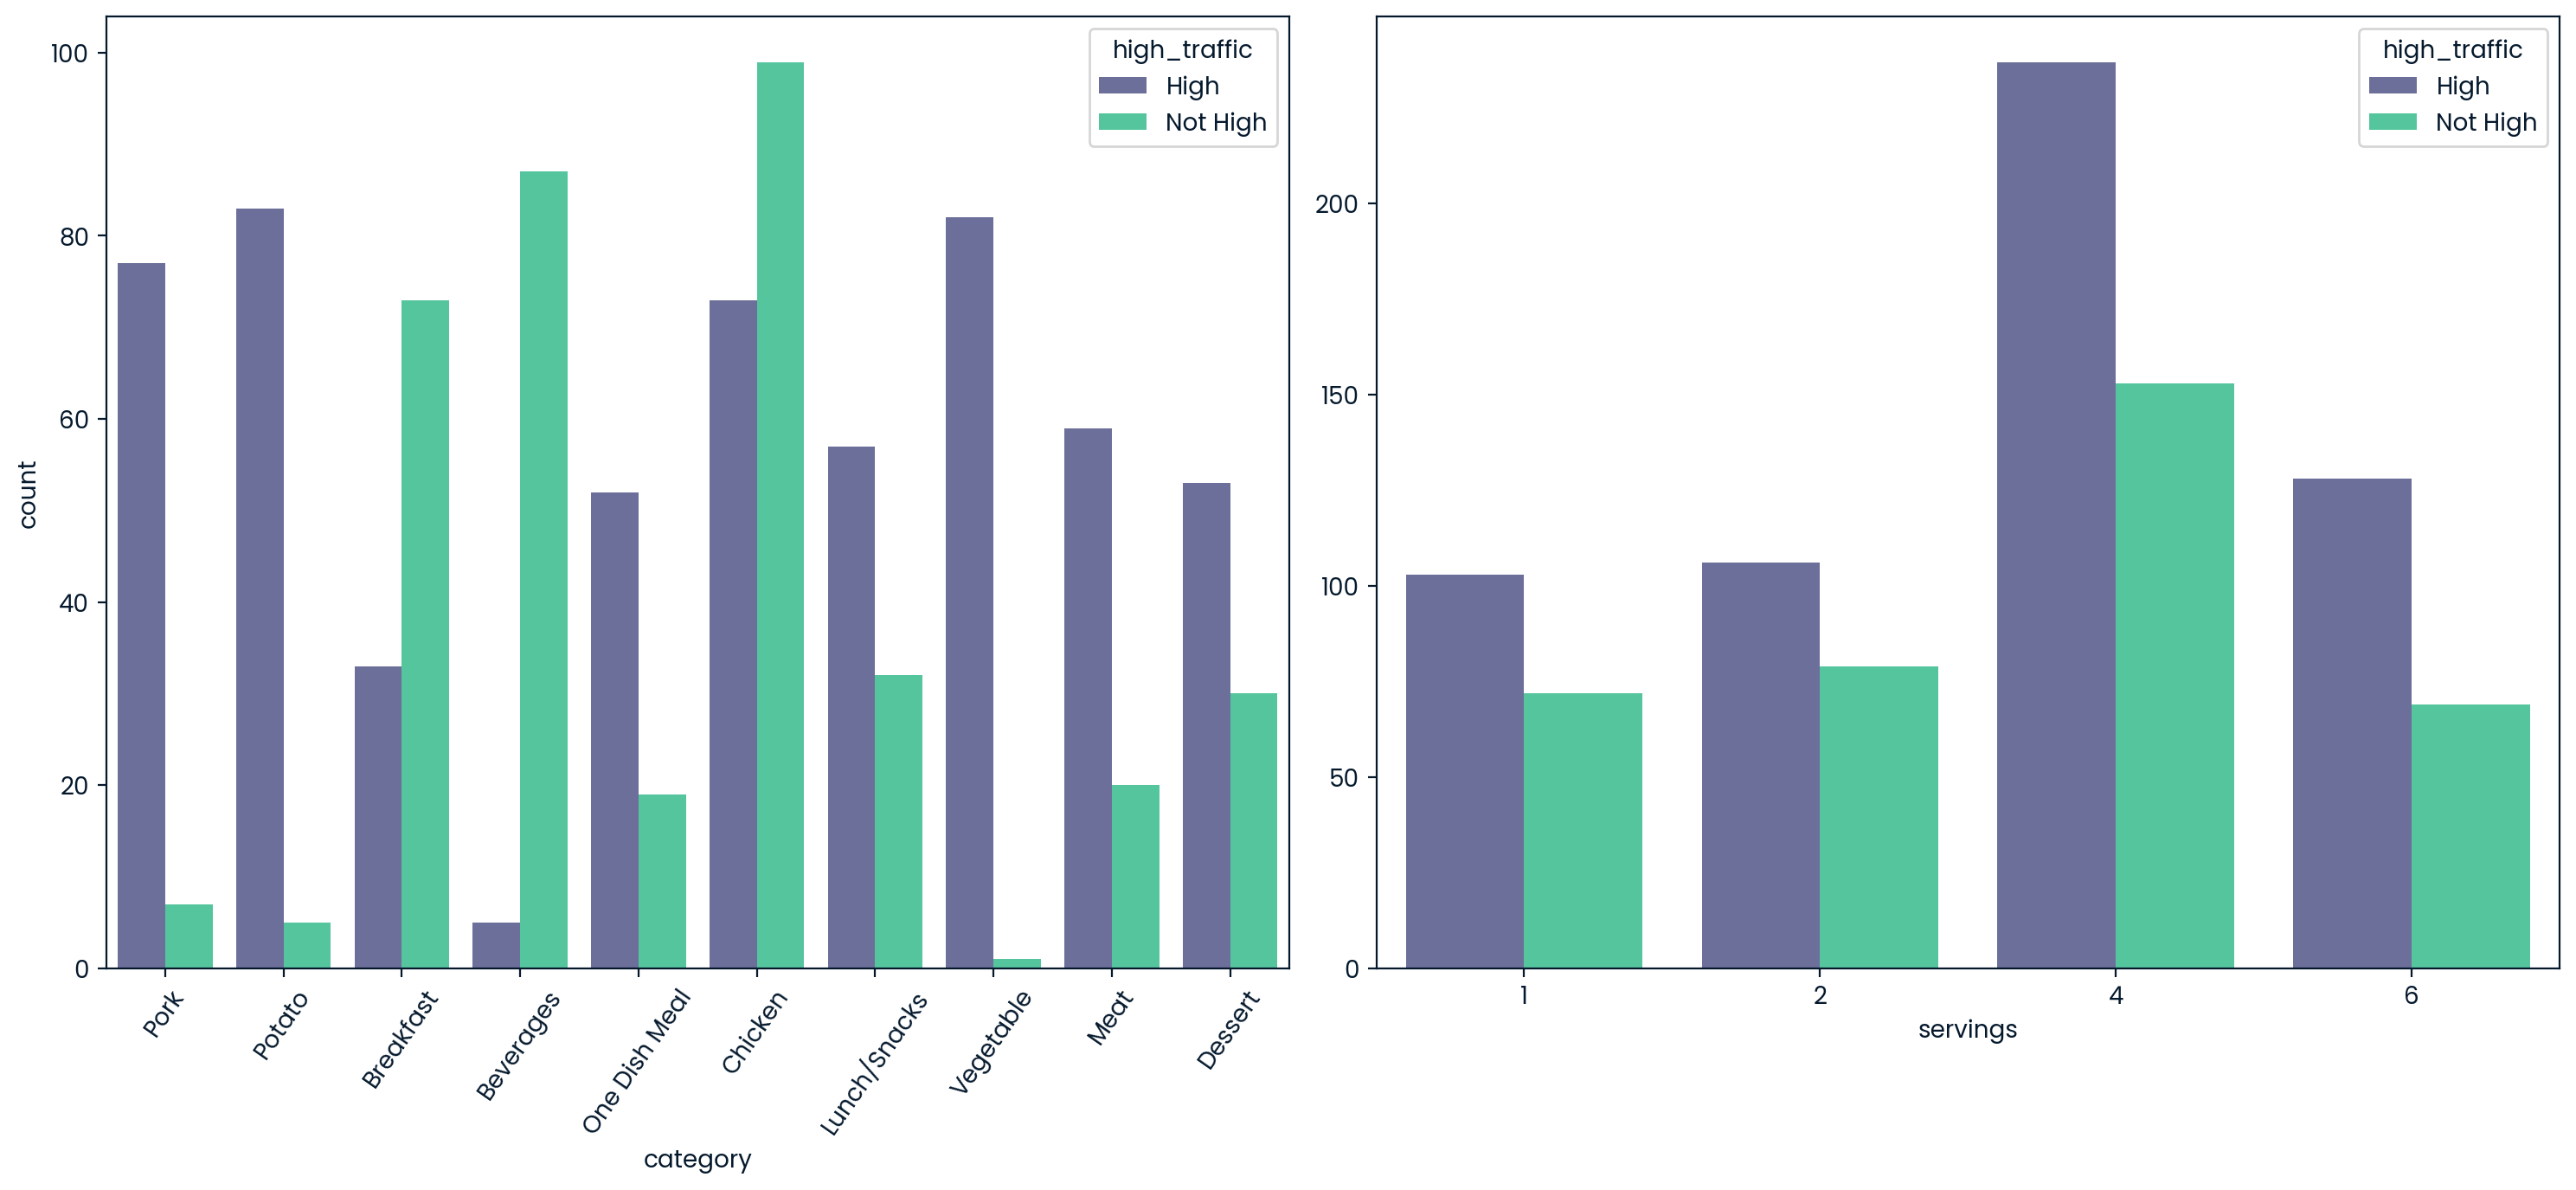

In [118]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize = (15, 7))

sns.countplot(x='category', data=recipes_cleaned, hue='high_traffic', ax=ax[0])
ax[0].tick_params(axis='x', rotation=55)

sns.countplot(x='servings', data=recipes_cleaned, hue='high_traffic', ax=ax[1])
ax[1].set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(hspace=0.1)

In [119]:
def chisquareTest(series1, series2):
    """
    Perform a Chi-square test for independence between two categorical series.

    Parameters
    ----------
    series1 : pandas.Series
        The first categorical series.
    series2 : pandas.Series
        The second categorical series.

    Returns
    -------
    p_value : float
        The p-value from the Chi-square test.
    """
        
    # Create a contingency table `series1` vs `series2`
    contingency_table = pd.crosstab(series1, series2)

    # Perform chi-square test
    chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)

    # Return p-value
    return p_value

In [120]:
# Define the significance level
alpha = 0.05

# Chisqure test between `category` and `high_traffic` variables
p_value_category = chisquareTest(recipes_cleaned['category'], recipes_cleaned['high_traffic'])

# Chisqure test between `servings` and `high_traffic` variables
p_value_servings = chisquareTest(recipes_cleaned['servings'], recipes_cleaned['high_traffic'])

# Interpretation of results for `category`
if p_value_category <= alpha:
    print('There is a statistically significant relationship between the `category` and `high_traffic` variables')
else:
    print('There is no statistically significant relationship between the `category` and `high_traffic` variables')

# Interpretation of results for `servings`
if p_value_servings <= alpha:
    print('There is a statistically significant relationship between the `servings` and `high_traffic` variables')
else:
    print('There is no statistically significant relationship between the `servings` and `high_traffic` variables')

There is a statistically significant relationship between the `category` and `high_traffic` variables
There is no statistically significant relationship between the `servings` and `high_traffic` variables


## Model Development
The buisness goal is to predict whether a recipe will bring a high traffic to the site or not when putting it in the home page, so this is a **binary classification problem**. <br> For this task I decided to chose the following models:
- **Logistic Regression (baseline):** A linear model that is known for its simplicity and interpretability, it performs well in binary classification problems and it is computationally efficient, making it a good candidate for quick training and evaluation.<br>
- **Support Vector Classifier (comparaison):** Chosen as comparaison model typically perform better with high-dimensional can be used with various kernel functions that allow it to create non-linear decision boundaries, which is good to capture non-linear relationships.

### Preparing data for modeling
To enable modeling, I chose `calories`, `carbohydrate`, `sugar`, `protein`, and `category` as features, `high_traffic` as target variables, the target variable already label encoded previously store in `high_traffic_enc` column. I also have made the following changes:

- The numeric features (i.e, `calories`, `carbohydrate`, `sugar`, and `protein`) was standardized using RobustScaler as they contain outliers.
- One-hot encoded the `category` variable.
- Split the data into a training set and a test set, with stratifying the target variable in both sets.

In [121]:
# Subset the features for modeling
features = recipes_cleaned[['calories', 'carbohydrate', 'sugar', 'protein', 'category']]

In [122]:
# Target variable 
y = recipes_cleaned['high_traffic_enc']

In [123]:
# One-hot label encoding the `category` varible, then assign the features to X
X = pd.get_dummies(features, drop_first=True, prefix='', prefix_sep='')

In [124]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Initialize a RobustScaler
scaler = RobustScaler()

# Fit the scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize a Logistic Regression model
lg = LogisticRegression()

# Define a grid of hyperparameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],  
    'max_iter': [100, 200],  
    'fit_intercept': [True, False],  
    'multi_class': ['auto', 'ovr', 'multinomial']  
}

# Perform Grid Search with cross-validation
grid_lg = GridSearchCV(lg, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)

# Fit the GridSearchCV model
grid_lg.fit(X_train_scaled, y_train)

# Extract the best estimator
base_model = grid_lg.best_estimator_

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


### Feature importance of Logistic regression model

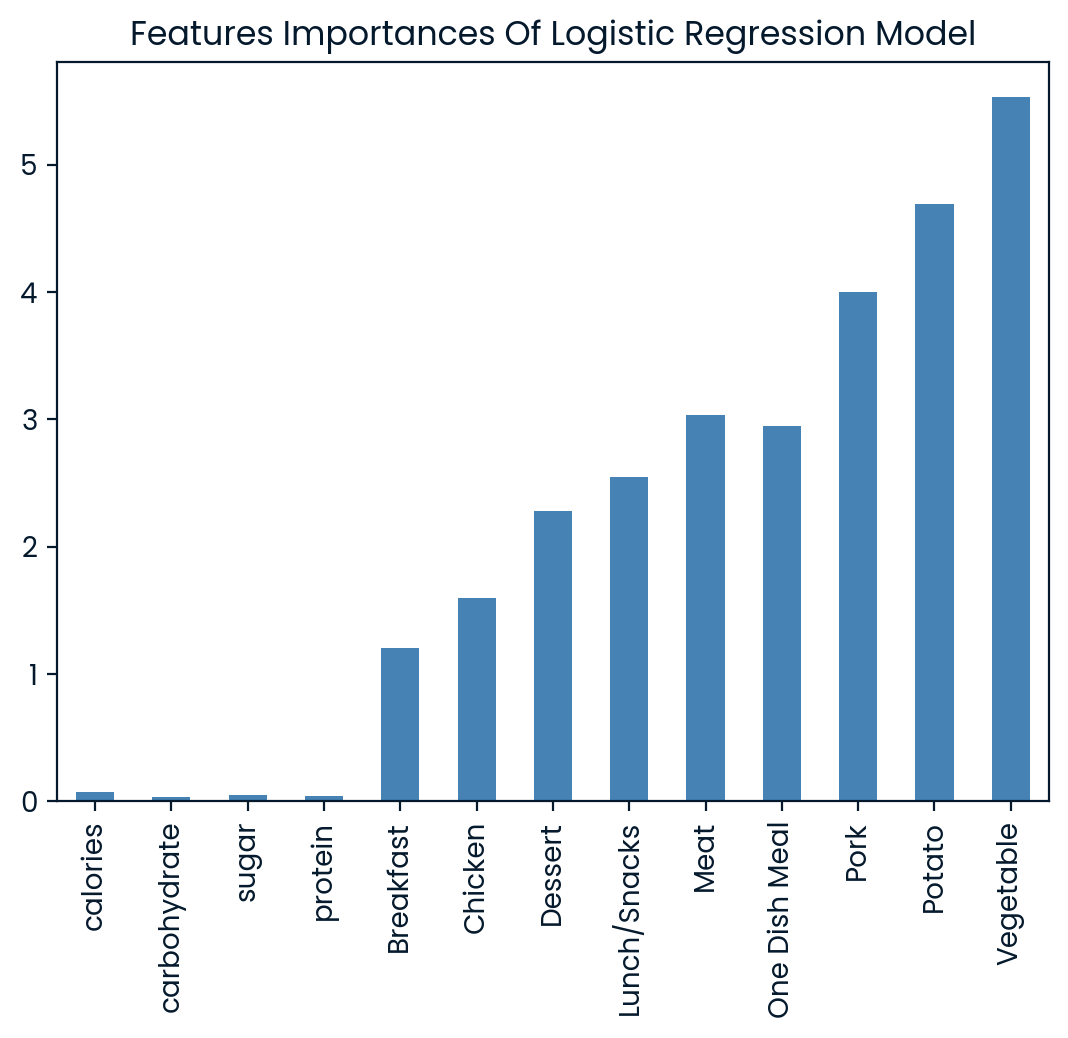

In [125]:
# Create a pd.Series of features importances
importances = pd.Series(data=base_model.coef_[0],
                        index= X.columns)

# Draw a barplot of importances
importances.plot(color='steelblue', kind='bar')
plt.title('Features Importances Of Logistic Regression Model')
plt.show()

In [126]:
# Initialize a Logistic Regression model
svc = SVC(random_state=42)

# Define a grid of hyperparameters
param_grid = {
    'C': [0.01, 0.1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [1, 4, 6]
}

# Instantiate grid_svc
grid_svc = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring='accuracy',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

# Fit the GridSearchCV model
grid_svc.fit(X_train_scaled, y_train)

# Extract the best estimator
comp_model = grid_svc.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits


## Model Evaluation
For evaluation, I chose precision as the primary metric for our KPI, with accuracy as a secondary metric for comparing the two models.
- As the business goal is to maximize website traffic, it is crucial to avoid promoting recipes that don’t perform well. High **precision** indicates a lower rate of false positives, meaning that when the model predicts a recipe will attract traffic, it is likely to do so. This approach ensures that we promote recipes that are expected to increase website traffic.
- **Accuracy** is an intuitive and straightforward metric that is easily understood by stakeholders. It provides a comprehensive view of the model's overall performance, making it a valuable secondary metric for evaluation. This is why **accuracy** was chosen as a secondary metric.

### Logistic Regression Model

In [127]:
# Predict test set labels
y_pred = base_model.predict(X_test_scaled)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precision : {precision:.2}') 
print(f'Accuracy : {accuracy:.2}') 

Precision : 0.83
Accuracy : 0.77


### Support Vector Classifier Model

In [128]:
# Predict test set labels
y_pred = comp_model.predict(X_test_scaled)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precision : {precision:.2}') 
print(f'Accuracy : {accuracy:.2}') 

Precision : 0.82
Accuracy : 0.75


### Results
The Linear Regression Model achieved a precision of 83%, which means that it predicts a recipe will bring high traffic to the website 83% of the time. Its accuracy of 77% suggests that the overall predictions made by the model were correct.

In comparison, the Support Vector Classifier obtained a precision of 82% and an accuracy of 75%.

Both models performed well in terms of precision, with the Linear Regression Model showing slightly higher precision, making it better than the Support Vector Classifier in this regard. The same applies to accuracy, further establishing the Linear Regression Model as the superior choice compared to the Support Vector Classifier.

## Evaluate by Business Criteria
The business goal is to predict recipes that will bring high traffic to the site 80% of the time.

As discussed above, the Logistic Regression Model performs well in both precision and accuracy, achieving 83% and 77%, respectively, compared to the Support Vector Classifier, which meets the business requirement.<br> 


The business should monitor precision as its primary KPI and accuracy as the secondary KPI to assess the overall performance of the model.

## Recommendations
To help the company predict which recipes are likely to bring traffic to the site, I recommend deploying the Logistic Regression model to automate the process. I will recommend the following steps to ensure the model can be deployed and improved regularly:
- Fully deploy the model using the best strategies.
- Collect more data, particularly on recipes that were not predicted to bring high traffic, to improve the model’s performance and make it more robust.
- Investigate and incorporate new features that may enhance the prediction process, such as user ratings.
- Regularly monitor the precision and accuracy of the model to ensure it continues to perform well and aligns with the company’s traffic goals.

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation